# K-means

Digamos que eres un analista de datos en Netflix y quieres explorar las similutdes y deferencias en los gustos de películas a partir de cómo califican estas. ¿Entender estos ratings contribuye a un sistema de recomendación de películas para los usuarios?

Utilizaremos el dataset [MovieLens](https://movielens.org/). Iniciaremos comparando los géneros y luego procederemos a observar los ratings individuales.

## Dataset
Puedes revisar info general del dataset aquí: https://grouplens.org/datasets/movielens/

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import helper

movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [36]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [37]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100004  ratings of  9125  movies.


# Romance vs. Scifi
Iniciaremos tomando un subconjunto de los usuarios y viendo sus géneros preferidos. Para este cuaderno, gran parte del preprocesamiento ya está implementado en funciones helper para que te puedas enfocar en clustering. Te sugiero dar una revisada a los nombres de las funciones de `helper.py` y revises cómo están implementadas de manera general.

In [38]:
# Calculate the average rating of romance and scifi movies

genre_ratings = helper.get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
userId,,
1,3.50,2.40
2,3.59,3.80
3,3.65,3.14
4,4.50,4.26
5,4.08,4.00


La función `get_genre_ratings` calculó el rating promedio para todas las películas románticas y de scifi para cada usuario. Vamos a aumentar un poco el bias en el dataset y eliminaremos a las personas a las que le gsutan ambos tipos de películas, sólo para que los clusters puedan definir los usuarios como si les gustara más un género que el otro.

In [5]:
biased_dataset = helper.bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  183


,userId,avg_romance_rating,avg_scifi_rating
0,1,3.50,2.40
1,3,3.65,3.14
2,6,2.90,2.75
3,7,2.93,3.36
4,12,2.89,2.62


Tenemos 183 usuarios y para cada usuario tenemos el rating promedio para los dos géneros. Vamos a hacer un plot:

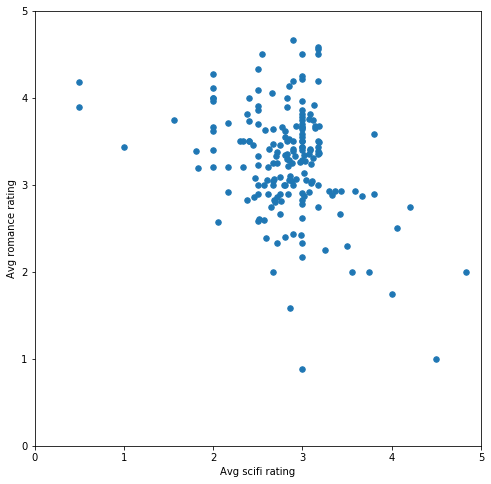

In [6]:
%matplotlib inline

helper.draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

In [7]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

* Importa KMeans de scikit learn
* Preparalo para 2 clusters
* Envía el dataset X al método `fit_predict` y revisa las predicciones

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

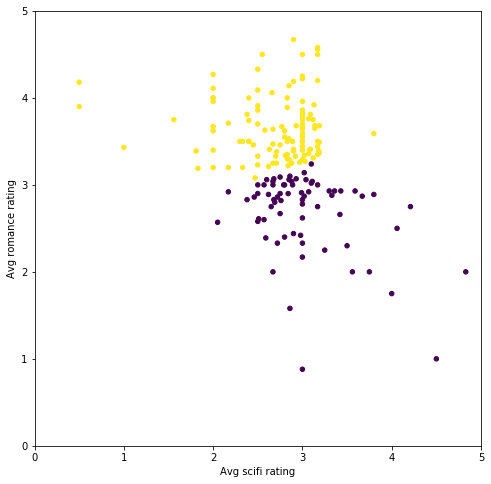

In [8]:
# TODO: Import KMeans
from sklearn.cluster import KMeans

# TODO: Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# TODO: use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Plot
helper.draw_clusters(biased_dataset, predictions)

Podemos ver que el grupo realmente sólo depende de cómo se ha calificado las películas románticas. Si el ratng es mayor a 3, pertenece a un grupo. Sino, pertenece al otro.

Repitamos pero haciendo 3 grupos y veamos qué ocurre:

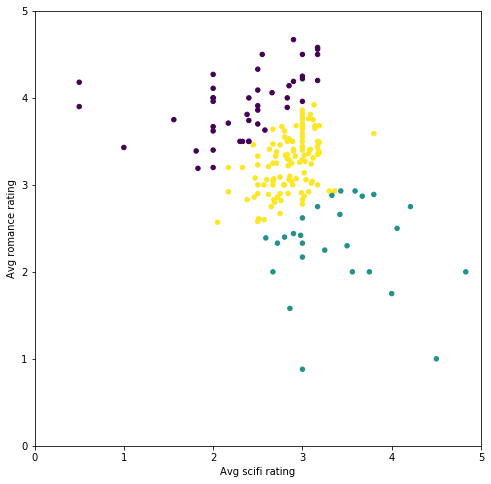

In [9]:
# TODO: Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)

# TODO: use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)

# Plot
helper.draw_clusters(biased_dataset, predictions_2)

Ahora el rating en scifi si se usa. Los grupos son
* Si te gusta romance pero no scifi
* Si te gusta scifi pero no romance
* Si te gustan ambas

Repitamos pero con 4 clusters:

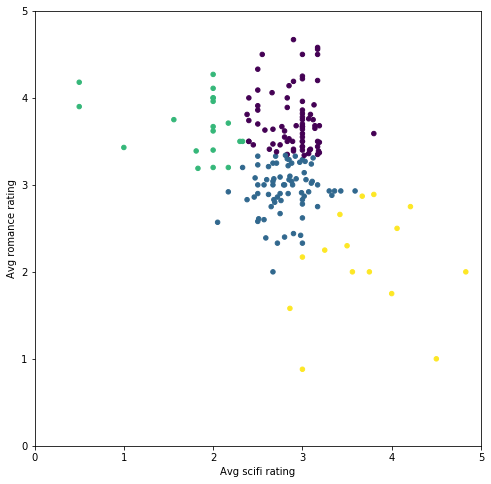

In [10]:
# TODO: Create an instance of KMeans to find four clusters
kmeans_3 = KMeans(n_clusters=4)

# TODO: use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)

# Plot
helper.draw_clusters(biased_dataset, predictions_3)

Como puedes ver, mientras tengamos más clusters, más parecido son los gustos de las personas en cada cluster.

## Elegir K
¿Cuál es el número correcto de clusters? Hay [muchas](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) maneras de determinar el número de clusters, K. Utilizaremos un método simple llamado "elbow method". Este método trabaja haciendo un plot de valores ascendentes de k vs el error calculado de cada k. Una manera de calcular el error es el error cuadrado. Digamos que k=2. Tendremos dos clusters con un punto centroide. Para cada punto del dataset, calculamos la distancia con cada punto, la elevamos al cuadrado y los sumamos. Esto nos da el error de cada punto. Si sumamos todos los errores, nos da el error total cuando k=2. Nuestro objetivo es calcular el error para cada K, desde 1 hasta un número definido, que puede ser el número total de elementos en el dataset.

In [11]:
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5) # El 5 es para ir dando saltos de 5 en 5

# Calculate error values for all k values we're interested in
errors_per_k = [helper.clustering_errors(k, X) for k in possible_k_values]

In [12]:
# Optional: Look at the values of K vs the silhouette score of running K-means with that value of k
list(zip(possible_k_values, errors_per_k))

[(2, 0.35588178764728268),
 (7, 0.38621690482169391),
 (12, 0.34813630096886261),
 (17, 0.37671713972546711),
 (22, 0.36870530620709158),
 (27, 0.37747465810868264),
 (32, 0.36567252223564395),
 (37, 0.37138480458760087),
 (42, 0.37313027951090283),
 (47, 0.37781655707709427),
 (52, 0.3583429072087666),
 (57, 0.3581201778099195),
 (62, 0.35058847971546142),
 (67, 0.34033943223335716),
 (72, 0.34363720706169992),
 (77, 0.34869291493441268),
 (82, 0.33977878424881935),
 (87, 0.33858549437556212),
 (92, 0.33029340625040471),
 (97, 0.31400198389434675),
 (102, 0.31906786189543157),
 (107, 0.3087748990932413),
 (112, 0.28530546283008301),
 (117, 0.28440157808064542),
 (122, 0.26509591087860201),
 (127, 0.268774631943275),
 (132, 0.2459507058938889),
 (137, 0.22993378519975044),
 (142, 0.2165246768418882),
 (147, 0.19785413782790848),
 (152, 0.18383354255613291),
 (157, 0.16645071380369883),
 (162, 0.14759705165906709),
 (167, 0.12920960729960135),
 (172, 0.10075966098920461),
 (177, 0.06423

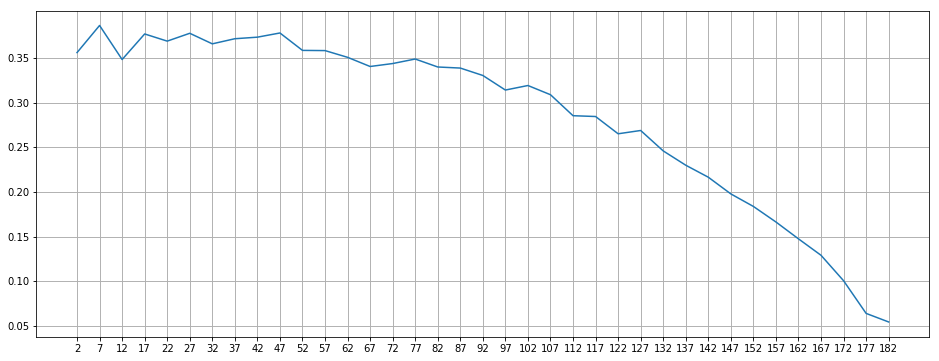

In [13]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

Aquí estamos graficando un puntaje (puntaje silueta). Algunas buenas decisiones de k incluyen 7, 22, 27, 32 y 47, entre otros. Seguir aumentando los valores de K empieza a resultar con peores clusters según este puntaje. Una buena decisión es K=7 porque es fácil de visualizar.

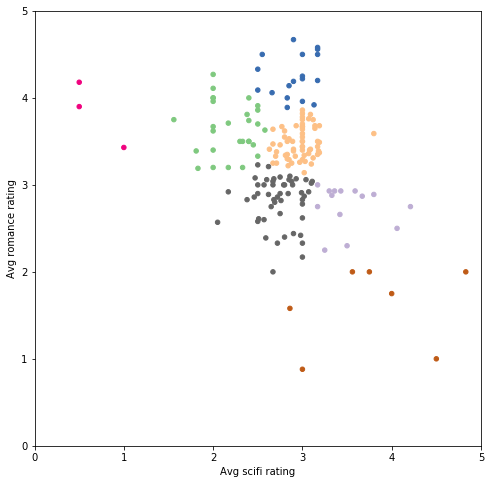

In [14]:
# TODO: Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)

# TODO: use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)

# plot
helper.draw_clusters(biased_dataset, predictions_4, cmap='Accent') 

Nota: Mientras intentes aumentar los valores de K, tendrás que asegurarte que tu librería de grafica no está reusando colores entre clusters. Aquí utilizamos cmap="Accent" justo para evitar eso y para evitar poco contraste.

## Agregando más géneros

Hasta el momento, sólo hemos utilizado el rating de romance y de películas de ciencia ficción. Es hora de agregar un género más: acción. Veamos cómo se ve el dataset.

In [15]:
biased_dataset_3_genres = helper.get_genre_ratings(ratings, movies, 
                                                     ['Romance', 'Sci-Fi', 'Action'], 
                                                     ['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
biased_dataset_3_genres = helper.bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  183


,userId,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,1,3.50,2.40,2.80
1,3,3.65,3.14,3.47
2,6,2.90,2.75,3.27
3,7,2.93,3.36,3.29
4,12,2.89,2.62,3.21


In [16]:
X_with_action = biased_dataset_3_genres[['avg_scifi_rating',
                                         'avg_romance_rating', 
                                         'avg_action_rating']].values

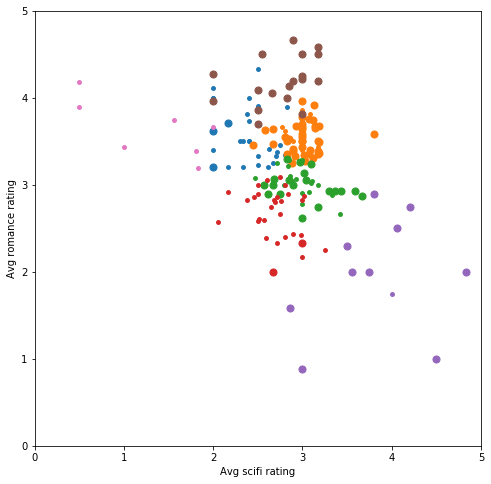

In [17]:
# TODO: Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)

# TODO: use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)

# plot
helper.draw_clusters_3d(biased_dataset_3_genres, predictions_5)

Todavía usamos x y y de la misma manera. Aquí, usamos el tamaño del punto para mostrar el rating de las películas de acción. Puntos grandes es si el rating es mayor a 3. Podemos ver cómo agregar un género cambió la manera en la que habían clusters. Mientras demos más información a k-means, los gustos de los usuarios en cada cluster serán más parecidos. Pero a la vez, perdemos la habilidad de visualizar qué está pasando si seguimos graficando de esta manera. Vamos a ver otras maneras de graficar que nos permitirán ver clusters de hasta 50 dimensiones.

# Clustering basado en películas

Ahora que hemos establecido un poco de conocimiento en cómo agrupamos usuarios según sus gustos de género, vamos a ver cómo los usuarios han puntuado películas individuales. Para hacer esto, vamos a cambiar la forma del dataset - veremos el userID vs el rating del usuario para cada película. Por ejemplo:

In [18]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (671, 9064) 

Subset example:


title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


NaN predomina porque los usuarios no han dado puntaje a todas las películas. Este tipo de datasets se llaman "sparse" o esparcidos porque sólo un pequeño número de celdas tienen valores.

Para poder seguir trabajando, vamos a ordenar según las películas con más ratings y los usuarios que hayan dado puntaje al mayor número de películas. Esto nos permitirá ver una zona más densa del dataset.

In [19]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = helper.sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Dances with Wolves (1990),Fight Club (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),"Lion King, The (1994)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Apollo 13 (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
29,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,...,5.0,4.0,5.0,4.0,3.0,5.0,3.0,5.0,4.0,2.0
508,4.0,5.0,4.0,4.0,5.0,3.0,4.5,3.0,5.0,2.0,...,5.0,4.0,5.0,4.0,3.5,5.0,4.5,3.0,2.0,4.0
14,1.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,4.0,4.0,...,3.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,4.0
72,5.0,5.0,5.0,4.5,4.5,4.0,4.5,5.0,5.0,3.0,...,4.5,5.0,5.0,5.0,5.0,5.0,5.0,3.5,3.0,5.0
653,4.0,5.0,5.0,4.5,5.0,4.5,5.0,5.0,5.0,5.0,...,4.5,5.0,5.0,4.5,5.0,4.5,5.0,5.0,4.0,5.0


Esto está mejor. Vamos a establecer una buena manera de visualizar esto para que luego podamos aplicarlo a clusters. Usemos colores en vez de ratings.

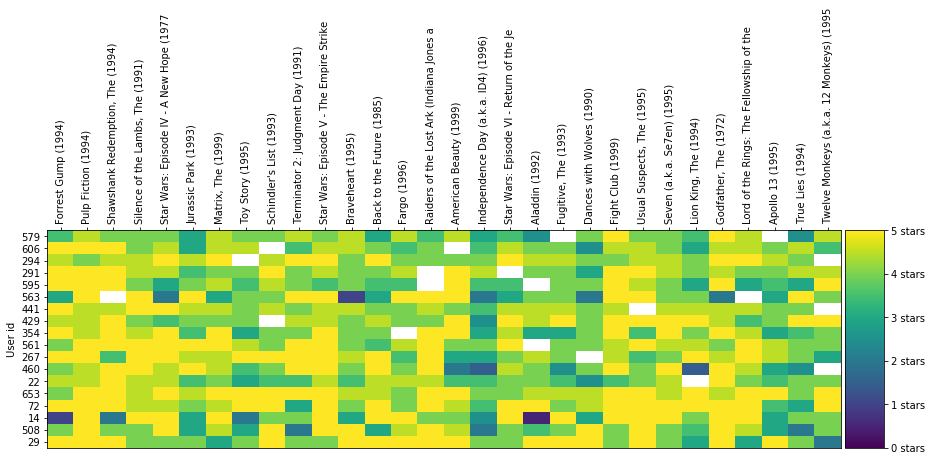

In [20]:
helper.draw_movies_heatmap(most_rated_movies_users_selection)

Cada columna indica una película. Cada fila indica un usuario. El color de la celda indica de qué manera el usuario puntuó la película específica basándose en la escala indicada en la derecha. Unas celdas son blancas. Estas implican que ese usuario respectivo no calificó la película. Esto es muy común en clustering en la vida real. Por lo tanto, no es tan directo como hicimos antes. Por razones de desempeño y poder computacional, sólo vamos a utilizar ratings de mil películas en vez de los más de 9mil que tenemos disponibles.

In [21]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = helper.get_most_rated_movies(user_movie_ratings, 1000)

Para que sklearn pueda correr k-means clustering en un dataset que le faltan valores, primero debemos convertirlo a una matriz de tipo sparse csr. Esto está definido en la librería SciPi. Para convertir un dataframe de Pandas a una matriz esparcida, tendremos que convertirla a `SparseDataFrame` y luego utilizar el método `to_coo()` para convertirlo.

In [22]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

## Clustering
Vamos a iniciar con k=20, pero aquí, de preferencia, podrías utilizar el método que utilizamos antes para determinar K. Esto tardaría algo de tiempo en procesar.

In [23]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

/Users/osanseviero/Documents/GitHub/CursoML/Semana6/1-K-Means/helper.py:115: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/Users/osanseviero/Documents/GitHub/CursoML/Semana6/1-K-Means/helper.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)


cluster # 11
# of users in cluster: 239. # of users in plot: 70


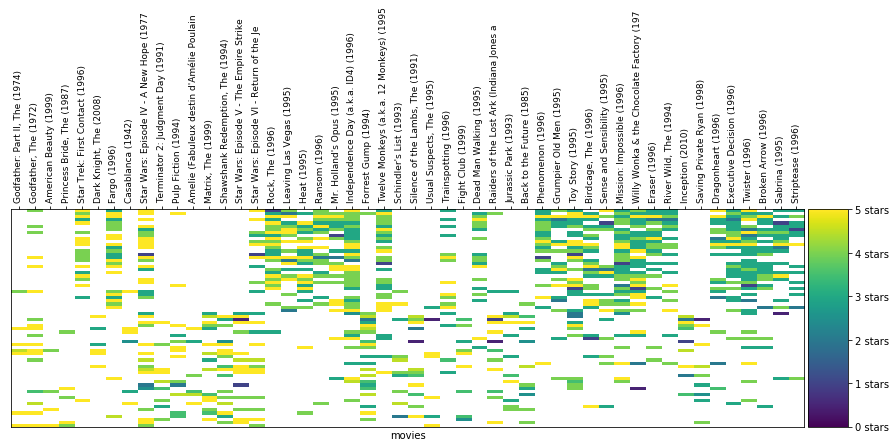

cluster # 7
# of users in cluster: 78. # of users in plot: 70


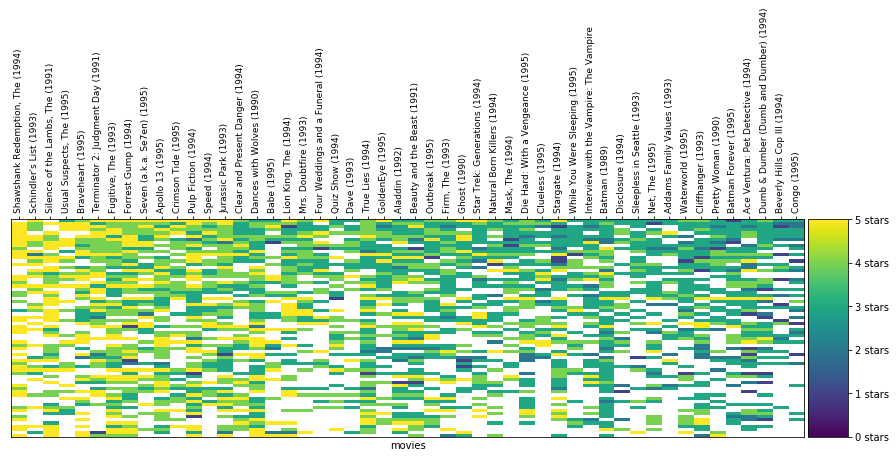

cluster # 4
# of users in cluster: 87. # of users in plot: 70


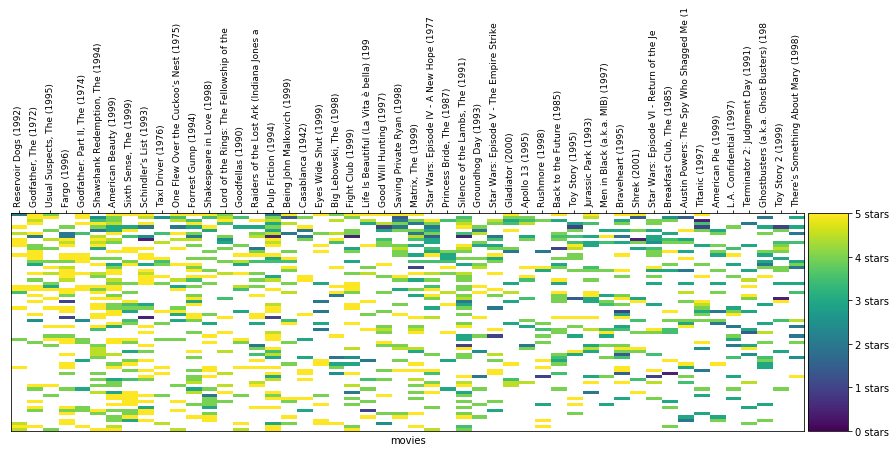

cluster # 12
# of users in cluster: 38. # of users in plot: 38


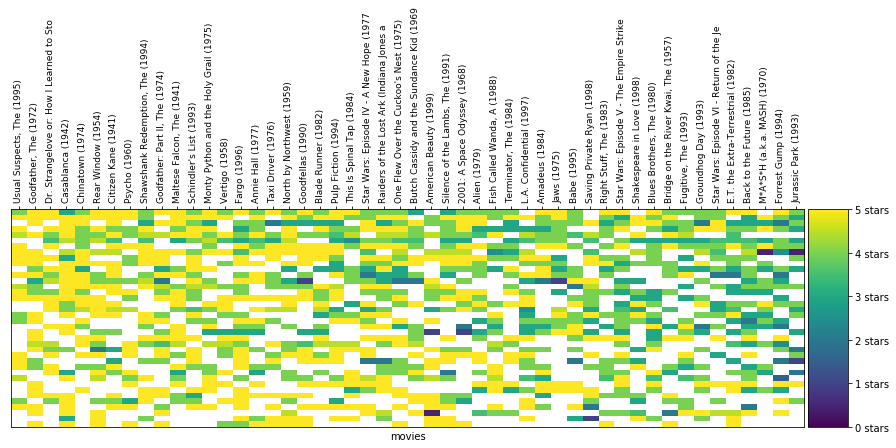

cluster # 0
# of users in cluster: 37. # of users in plot: 37


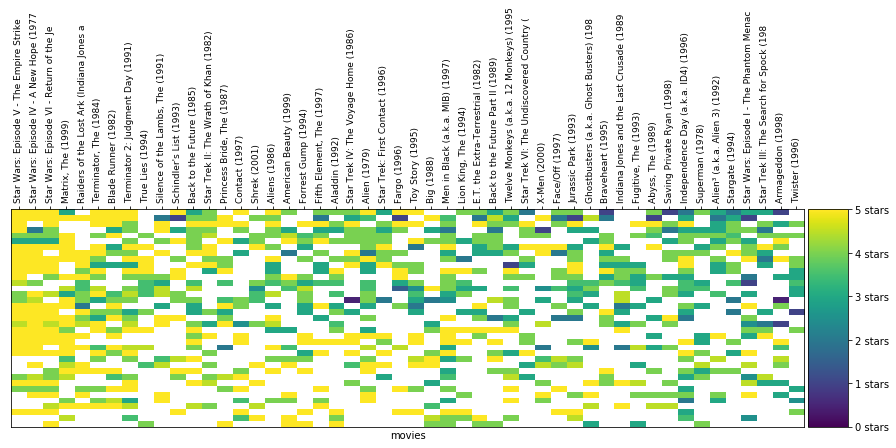

cluster # 13
# of users in cluster: 33. # of users in plot: 33


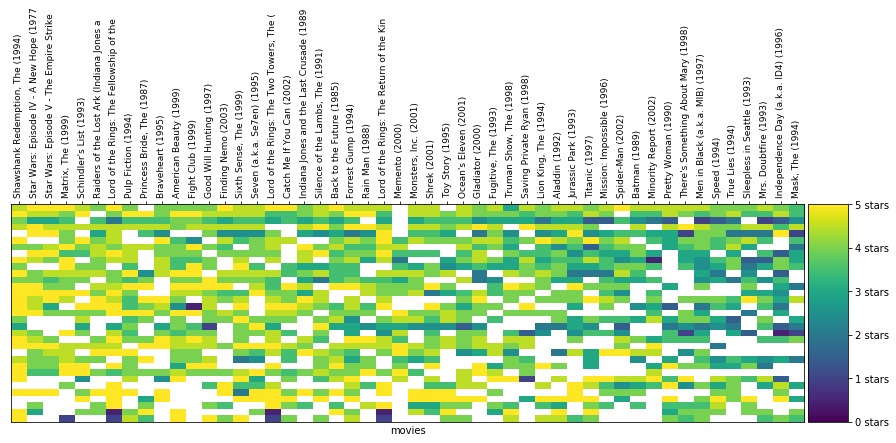

cluster # 9
# of users in cluster: 92. # of users in plot: 70


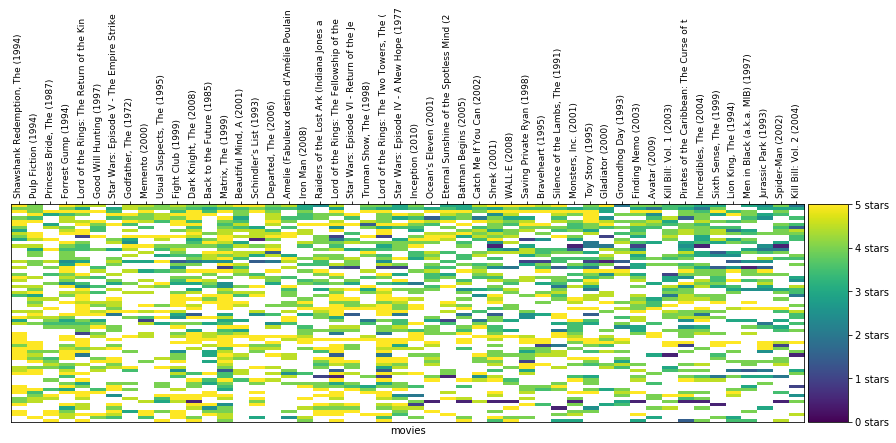

cluster # 19
# of users in cluster: 18. # of users in plot: 18


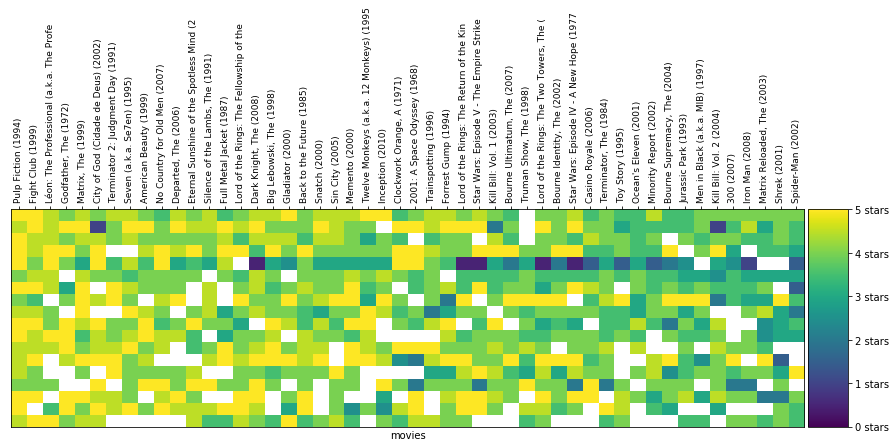

cluster # 14
# of users in cluster: 14. # of users in plot: 14


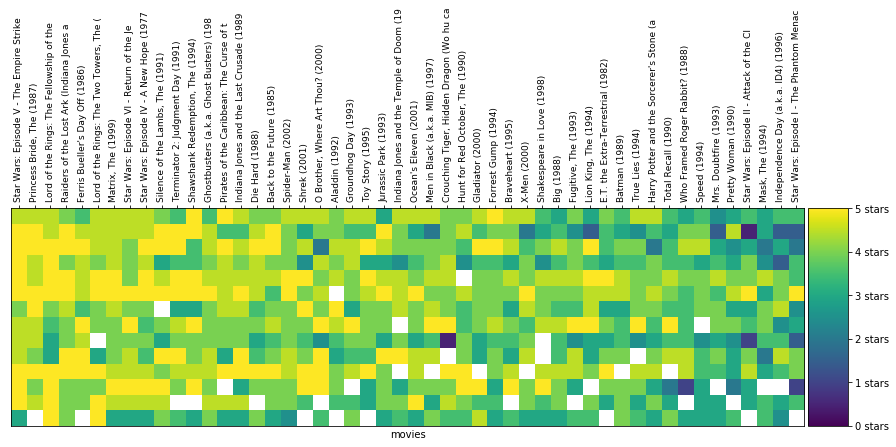

cluster # 6
# of users in cluster: 10. # of users in plot: 10


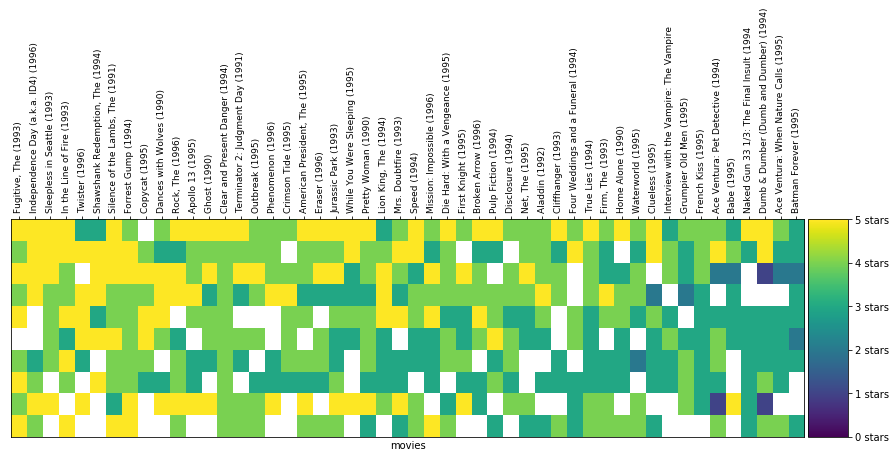

In [24]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
helper.draw_movie_clusters(clustered, max_users, max_movies)

Hay varias cosas que notar
* Lo más similares los ratings de un cluster son, podrás ver más líneas verticales con el mismo color.
* Puedes encontrar patrones en los clusters:
  * Algunos clusters están más esparcidos que otros, conteniendo personas que vieron y calificaron menos películas que en otros clusters.
  * Algunos clusters son principalmente amarillos y tienen los usuarios que realmente les gusta un grupo de películas.
  * Otros clusters son principalmente verde o azul marino. Estos contienen usuarios que están de acuerdo en que ciertos conjuntos de películas tienen 2-3 estrellas.
  * Mira cómo las películas son diferentes en cada cluster. La gráfica filtra la información para mostrar únicamente las películas con más ratings y luego los ordena según promedio.
* Si detectas líneas horizontales de colores similares, son usuarios que no tienen mucha variedad en sus ratings. Esta es una de las razones por las que Netflix cambió de un sistema basado en estrellas a un sistema basado en thumbs-up. Un rating de 4 estrellas significa diferentes cosas a diferentes personas.

## Predicciones
Vamos a agarrar un cluster y un usuario específico y veamos para qué nos sirve esto.

Primero agarremos un cluster:

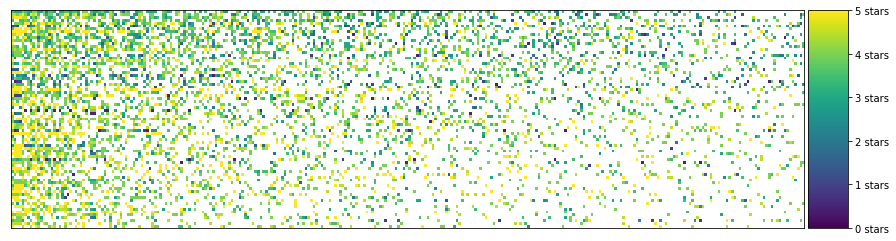

In [30]:
# TODO: Pick a cluster ID from the clusters above
cluster_number = 9

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = helper.sort_by_rating_density(cluster, n_movies, n_users)
helper.draw_movies_heatmap(cluster, axis_labels=False)

In [31]:
cluster.fillna('').head()

,"Matrix, The (1999)","Lord of the Rings: The Fellowship of the Ring, The (2001)","Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Forrest Gump (1994),"Dark Knight, The (2008)",Star Wars: Episode IV - A New Hope (1977),Shrek (2001),Fight Club (1999),"Shawshank Redemption, The (1994)",...,My Big Fat Greek Wedding (2002),"Graduate, The (1967)",Stargate (1994),Grease (1978),"Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)","Life Aquatic with Steve Zissou, The (2004)",Amadeus (1984),Animal House (1978),Signs (2002),"Hunt for Red October, The (1990)"
8,3.5,3,3,3,4,3.5,3,3,4,4,...,,,,,,,,,,
12,4.5,4.5,4,4.5,5,4,3,5,4.5,5,...,,,2.5,,,,,,1.5,4
57,4.5,5,5,5,4.5,4.5,,3,4,3,...,,,,,,,,,3,
20,3.5,,,3.5,3.5,4,3.5,,4,4.5,...,,,,,,,,,,
58,,4,4,4,3.5,5,5,2.5,5,,...,,,,,4.5,,,4,1.5,


Vamos a elegir una celda vacía de la tabla. Están vacías porque el usuario no calificó la película. ¿Podemos predecir si al usuario le gustó o no? Dado que el usuario está en un cluster con otros usuarios que parecen tener gustos similares, podemos tomar esto como ventaja y sacar el promedio de los ratings para esa película para predecir si le gustará o no.

In [32]:
# TODO: Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"

cluster[movie_name].mean()

4.1538461538461542

## Recomendaciones
Vamos a reiterar en lo que acabamos de hacer. Utilizamos k-means para hacer clusters de usuarios según los ratings. Esto nos llevo a hacer clusters de usuarios con ratings similares y así generalizando gustos similares de películas. Basado en esto, cuando un usuario no tenía el puntaje de una película especifica, podíamos sacar el promedio en el cluster y predecir qué rating el usuario le daría. Usando esta lógica, podemos calcular el promedio de cada película del cluster y así entender cómo se siente el cluster para cada película.

In [33]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Matrix, The (1999)                                                                4.153846
Lord of the Rings: The Fellowship of the Ring, The (2001)                         4.017544
Lord of the Rings: The Two Towers, The (2002)                                     3.991525
Lord of the Rings: The Return of the King, The (2003)                             4.173077
Forrest Gump (1994)                                                               4.219298
Dark Knight, The (2008)                                                           4.141304
Star Wars: Episode IV - A New Hope (1977)                                         4.043478
Shrek (2001)                                                                      3.849057
Fight Club (1999)                                                                 4.163265
Shawshank Redemption, The (1994)                                                  4.533333
Pirates of the Caribbean: The Curse of the Black Pearl (2003)                     3.784314

Esto es muy útil para nosotros - podemos usar esto para un motor de recomendación que permite a los usuarios descubrir nuevas películas que les gustarán. Usamos las películas con rating más alto que el usuario no haya calificado todavía.

In [34]:
# TODO: Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 19

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

12 Angry Men (1957)                                    4.500000
Back to the Future Part II (1989)                      4.444444
Harry Potter and the Deathly Hallows: Part 2 (2011)    4.428571
The Imitation Game (2014)                              4.428571
Intouchables (2011)                                    4.428571
City of God (Cidade de Deus) (2002)                    4.411765
Kung Fu Panda (2008)                                   4.392857
Prestige, The (2006)                                   4.388889
Breakfast Club, The (1985)                             4.382353
Lock, Stock & Two Smoking Barrels (1998)               4.368421
Monty Python and the Holy Grail (1975)                 4.365385
Pulp Fiction (1994)                                    4.363636
Blood Diamond (2006)                                   4.291667
Big Lebowski, The (1998)                               4.285714
King's Speech, The (2010)                              4.266667
How to Train Your Dragon (2010)         